In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as BS
from datetime import datetime
import numpy as np
import re
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import CARTODBPOSITRON
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

# Clean Data

In [2]:
#import wiki code as text file

response = requests.get('https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900')
result_text = response.text

In [3]:
#convert text to soup

soup = BS(result_text, 'html.parser')

In [4]:
# convert headers to list

column_headers = [th.getText() for th in 
                  soup.findAll('th')]

In [5]:
# create list of all data in table

data_rows = soup.findAll('tr')[6:] 

In [6]:
# parse out data in rows

earthquake_data = [[td.getText() for td in data_rows[i].findAll('td')]
            for i in range(len(data_rows))]

In [7]:
3

df = pd.DataFrame(earthquake_data, columns=column_headers)

In [8]:
df.columns = ['origin','country','lat','lng','depth','magnitude','secondary_effects','pde_shaking_deaths','pde_total_deaths','utsu_total_deaths','emdat_total_deaths','other_deaths']

In [9]:
df['origin'] = pd.to_datetime(df.origin)

In [10]:
df.other_deaths = df.other_deaths.str[:-1]

In [11]:
#replace all blank cells with NaN

df = df.replace('', np.NaN)

In [12]:
#resolve any weird data errors that have a comma, footnote, or aren't formatted correctly to convert to number

df.at[43, 'other_deaths'] = 8000
df.at[66,'other_deaths'] = 164
df.at[99,'other_deaths'] = 1500
df.at[1078,'other_deaths'] = 45000
df.at[1082,'other_deaths'] = 2489
df.at[1206,'other_deaths'] = 26000
df.at[1238,'other_deaths'] = 283000
df.at[1339,'other_deaths'] = 601
df.at[1338,'other_deaths'] = 111
df.at[1336,'other_deaths'] = 150
df.at[1335,'other_deaths'] = 15894
df.at[1329,'other_deaths'] = 521
df.at[1328,'other_deaths'] = 221517
df.at[1318,'other_deaths'] = 60
df.at[439,'emdat_total_deaths'] = '10'
df.at[413,'emdat_total_deaths'] = ''
df.at[958,'other_deaths'] = '33'
df.at[1327,'other_deaths'] = '1115'
df.at[1332,'other_deaths'] = '2698'

In [13]:
#convert all deaths to numeric

df.pde_shaking_deaths = pd.to_numeric(df.pde_shaking_deaths)
df.pde_total_deaths = pd.to_numeric(df.pde_total_deaths)
df.utsu_total_deaths = pd.to_numeric(df.utsu_total_deaths)
df.emdat_total_deaths = pd.to_numeric(df.emdat_total_deaths)
df.other_deaths = pd.to_numeric(df.other_deaths)

In [14]:
#create a column called total deaths that has the max of the deaths columns

df['total_deaths'] = df.iloc[:,-5:].max(axis = 1)

In [15]:
#change anywhere with NaN deaths to 0 deaths

df['total_deaths'] = df.total_deaths.fillna(0)

In [16]:
#Use regex to remove all the parentheses info in the Country column

df.country = df.country.str.replace(r"\(.*\)","")
df.country = df.country.str.replace(r"\(.*","")

In [17]:
# Extract number on magnitude scale

df.magnitude = df.magnitude.str[0:3]

In [18]:
# Clean weird cell

df.at[439, 'magnitude'] = "5.0"

In [19]:
# Convert magnitude to numeric

df.magnitude = pd.to_numeric(df.magnitude)

# Analysis

## Earthquakes
- Nate Silver discusses the difficulty of predicting earthquakes in The Signal and the Noise, but are there factors that make an earthquake more likely?
- Are there factors that make an earthquake more deadly?
- Where would you live if you wanted to eliminate the risk of experiencing an earthquake?
- Where would you avoid living?

In [20]:
df.country.value_counts(dropna = False).head()

China        133
Indonesia     82
Iran          78
Japan         62
Turkey        60
Name: country, dtype: int64

In [21]:
df.head()

,origin,country,lat,lng,depth,magnitude,secondary_effects,pde_shaking_deaths,pde_total_deaths,utsu_total_deaths,emdat_total_deaths,other_deaths,total_deaths
0,1900-05-11 17:23:00,Japan,38.700,141.100,5,7.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1900-07-12 06:25:00,Turkey,40.300,43.100,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN,140.0
2,1900-10-29 09:11:00,Venezuela,11.000,-66.000,0,7.7,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,1901-02-15 00:00:00,China,26.000,100.100,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,1901-03-31 07:11:00,Bulgaria,43.400,28.700,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN,4.0


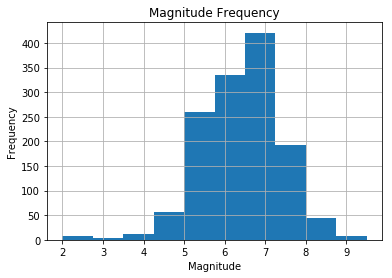

In [22]:
df.magnitude.hist()
plt.title("Magnitude Frequency")
plt.xlabel('Magnitude')
plt.ylabel('Frequency');

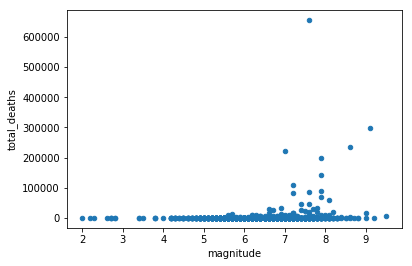

In [23]:
df.plot(kind = 'scatter', x = 'magnitude', y='total_deaths');

In [24]:
df.total_deaths.describe()

count      1340.000000
mean       2353.696269
std       23393.108847
min           0.000000
25%           2.000000
50%           8.000000
75%          76.500000
max      655237.000000
Name: total_deaths, dtype: float64

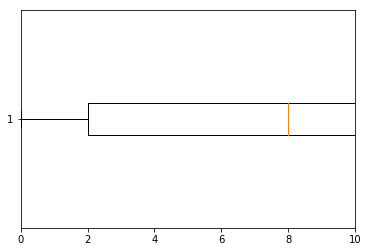

In [25]:
plt.boxplot(df.total_deaths, vert = False)
plt.xlim(0,10);

In [26]:
# output_file("tile.html")

# # range bounds supplied in web mercator coordinates
# p = figure(x_range=(-2000000, 6000000), y_range=(-1000000, 7000000),
#            x_axis_type="mercator", y_axis_type="mercator")
# p.add_tile(CARTODBPOSITRON)
# p.circle(x=df.lat, y=df.lng, size=10, color="red")

# show(p)

In [27]:
#population.to(gv.Points, kdims=['lat', 'lng'], crs=ccrs.PlateCarree())

In [28]:
df = df.drop(df.index[413])

In [29]:
df['geometry'] = df.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)

- Where would you live if you wanted to eliminate the risk of experiencing an earthquake?
- Where would you avoid living?

In [30]:
usa = pd.read_csv('/Users/rabram/Desktop/NSS/data-question-3-earthquakes-high-voltage-1/data/all_month.csv', usecols=[0,1,2,3,4])

In [31]:
usa.head()

,time,latitude,longitude,depth,mag
0,2018-09-25T23:55:30.290Z,33.508000,-116.800667,2.71,1.42
1,2018-09-25T23:47:51.764Z,60.195300,-153.153200,132.20,1.80
2,2018-09-25T23:38:40.870Z,33.515833,-116.788333,6.66,0.47
3,2018-09-25T23:37:40.574Z,60.934000,-152.458700,105.60,1.40
4,2018-09-25T23:34:28.040Z,33.335000,-116.166667,10.31,0.86


In [32]:
usa.columns = ['time','lat','lng','depth','magnitude']

In [33]:
usa['geometry'] = df.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)

In [34]:
usa.head()

,time,lat,lng,depth,magnitude,geometry
0,2018-09-25T23:55:30.290Z,33.508000,-116.800667,2.71,1.42,POINT (141.1 38.7)
1,2018-09-25T23:47:51.764Z,60.195300,-153.153200,132.20,1.80,POINT (43.1 40.3)
2,2018-09-25T23:38:40.870Z,33.515833,-116.788333,6.66,0.47,POINT (-66 11)
3,2018-09-25T23:37:40.574Z,60.934000,-152.458700,105.60,1.40,POINT (100.1 26)
4,2018-09-25T23:34:28.040Z,33.335000,-116.166667,10.31,0.86,POINT (28.7 43.4)


In [35]:
usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9937 entries, 0 to 9936
Data columns (total 6 columns):
time         9937 non-null object
lat          9937 non-null float64
lng          9937 non-null float64
depth        9937 non-null float64
magnitude    9935 non-null float64
geometry     1339 non-null object
dtypes: float64(4), object(2)
memory usage: 465.9+ KB


In [36]:
usa_geo = gpd.GeoDataFrame(usa, geometry = usa['geometry'])

TypeError: Input geometry column must contain valid geometry objects.

In [ ]:
states = gpd.read_file('/Users/rabram/Desktop/NSS/data-question-3-earthquakes-high-voltage-1/data/gz_2010_us_040_00_5m.json')

In [ ]:
usa_geo = gpd.GeoDataFrame(usa, crs = states.crs, geometry = usa['geometry'])